Modelo dummy altamente overfitteado pero un buen experimento. Cargamos módulos

In [2]:
import numpy as np
import pandas as pd
from utilities import *

Cargamos matrices de velocidad, extents, glaciares y máscaras. Para más información ver notebook `0_interferometria_triangulacion.ipynb`

In [7]:
c1 = np.load("../data/c_1/vel.npy")
c2 = np.load("../data/c_2/vel.npy")
c3 = np.load("../data/c_3/vel.npy")

extent1 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/c_1/extent.tsv", 
                      sep="\t", header=None).to_numpy()
extent2 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/c_2/extent.tsv", 
                      sep="\t", header=None).to_numpy()
extent3 = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/c_3/extent.tsv", 
                      sep="\t", header=None).to_numpy()

glaciares = {f"glaciar_{n}": pd.read_csv(f"https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/data/\
glaciares/glaciar_{n}_strict.tsv", sep="\t", header=None).to_numpy()[:-1, [1,0]] for n in range(1, 7)}

glaciares_list = list(glaciares.values())

con_glaciares = {f"glaciar_area_{n}": pd.read_csv(f"https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/\
data/glaciares/glaciar_area_{n}.tsv", sep="\t", header=None).to_numpy()[:-1, [1,0]] for n in range(1, 5)}
con_glaciares["argentina"] = pd.read_csv("https://raw.githubusercontent.com/alcazar90/rock-glacier-detection/main/\
data/glaciares/argentina.tsv", sep="\t", header=None).to_numpy()[:-1, [1,0]]

con_glaciares_list = list(con_glaciares.values())

en_glaciares_c1 = np.load("../data/masks/en_glaciar_c1.npy")
en_glaciares_c3 = np.load("../data/masks/en_glaciar_c3.npy")
sin_glaciares_c1 = np.load("../data/masks/sin_glaciar_c1.npy")
sin_glaciares_c3 = np.load("../data/masks/sin_glaciar_c3.npy")

Creamos los mappers para visualizar

In [8]:
mapper1 = mapper(extent1, c1.shape)
mapper3 = mapper(extent3, c3.shape)

Creamos los colormaps

In [9]:
colors = np.column_stack((np.ones((256, 3)), np.linspace(0, 1, 256)))
alpha = LinearSegmentedColormap.from_list(name = "alpha", colors=colors)
glow = LinearSegmentedColormap.from_list(name = "glow", colors=colors*np.array([0.97, 0.58, 0.2, 1]))
danger = LinearSegmentedColormap.from_list(name = "danger", colors=colors*np.array([0.85, 0.2, 0.45, 1]))
sky = LinearSegmentedColormap.from_list(name = "sky", colors=colors*np.array([0.25, 0.45, 0.95, 1]))

colors2 = np.array([[0, .95, 1,1], [0,0,0,1], [.75,.9,0,1]])
fluor = LinearSegmentedColormap.from_list(name = "fluor", colors=colors2)

# Regresión Logística

Se realiza un modelo que clasifica los puntos entre glaciar y no glaciar. Para esto, toma para cada punto uno de tres atributos opcionales: 1.- Su velocidad, 2.- Las diferencias de velocidad con los pixeles cercanos en un cierto rango y 3.- Las covarianzas entre estos pixeles. El mejor modelo (y el más generalizable) es aquél que sólo considera la diferencia entre el pixel con los cercanos sin considerarse a si mismo o la covarianza.

Luego, se da la opción de realizar max pooling para continuar la clasificación con los outputs. La probabilidad final es la multiplicación de las probabilidades por todas las capas, dandole mayor peso a las últimas capas.

Previo al entrenamiento, creamos una matriz que es true para los glaciares y no glaciares pero false para las zonas ambiguas, de forma que estas no se considerarán en el entrenamiento.

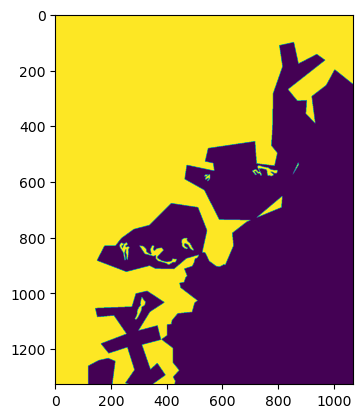

In [4]:
consider = np.any((en_glaciares_c3, sin_glaciares_c3), axis = (0))

plt.imshow(consider)

In [23]:
model_1 = conv_logreg(5, 5, itself=False, cov = False)

model_1.fit(c3, en_glaciares_c3, drop_matrix = consider)

Remaining layers: 4
Accuracy: 0.7646105192132867
True positives: 0.49087708066581304
False positives: 0.2331693386123191
Remaining layers: 3
Accuracy: 0.809264865364946
True positives: 0.578978978978979
False positives: 0.18874742091675392
Remaining layers: 2
Accuracy: 0.8272857435058294
True positives: 0.7170626349892009
False positives: 0.17166043735932435
Remaining layers: 1
Accuracy: 0.8590702210663199
True positives: 0.9022556390977443
False positives: 0.14140169254785967
Remaining layers: 0
Accuracy: 0.9633558341369335
True positives: 1.0
False positives: 0.03713355048859935


In [31]:
predicted = model_1.predict(c3, weight=2)

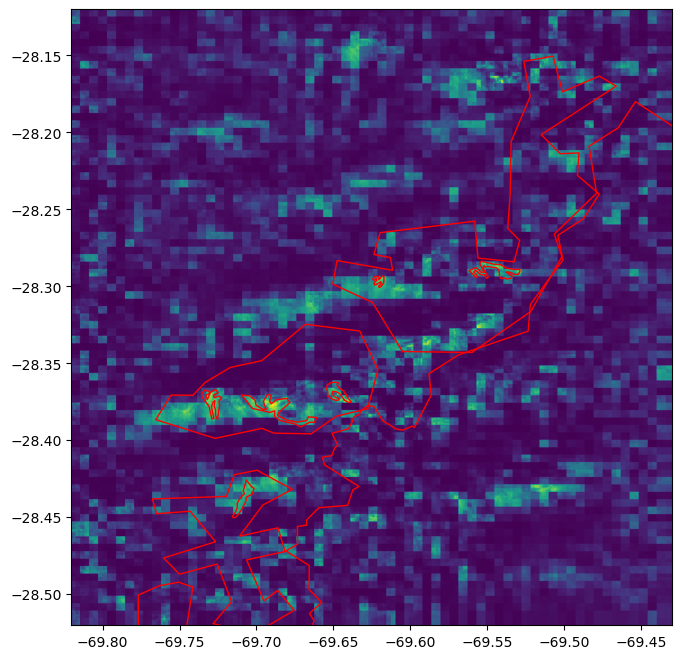

In [33]:
mapper3.draw(predicted, linecol="red", linewidth=1, glaciares = glaciares_list + con_glaciares_list, force_extent = True)

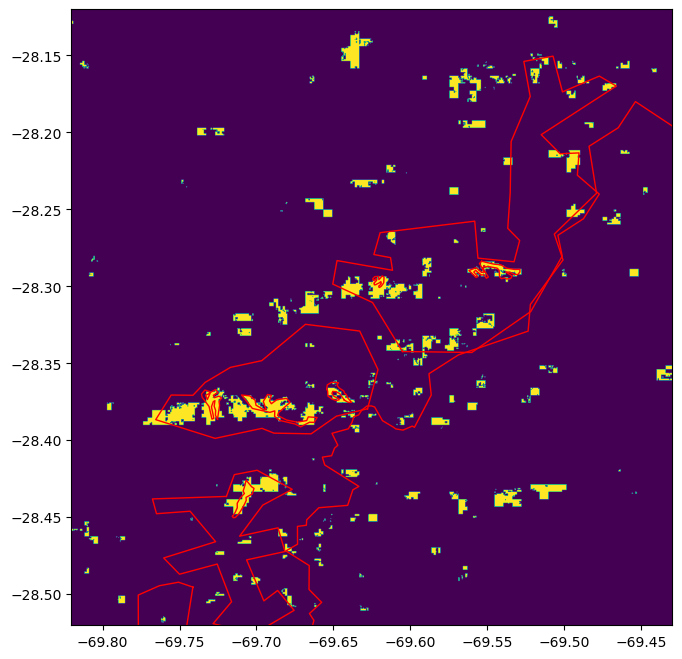

In [34]:
mapper3.draw(predicted>.5, linecol="red", linewidth=1, glaciares = glaciares_list + con_glaciares_list, force_extent = True)